# CHILDES Eng-NA: Age vs IPSyn Score

In [1]:
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
# List of CSV files to process
ipsyn_files_50 = ['Abe_ipsyn50.csv', 'Adam_ipsyn50.csv', 'Benjamin_ipsyn50.csv', 'Emily_ipsyn50.csv', 'Emma_ipsyn50.csv', 'Eve_ipsyn50.csv', 'Jillian_ipsyn50.csv', 'Laura_ipsyn50.csv', 'Matt_ipsyn50.csv', 'Naomi_ipsyn50.csv', 'Nathaniel_ipsyn50.csv', 'Nina_ipsyn50.csv', 'Roman_ipsyn50.csv', 'Ross_ipsyn50.csv', 'Shem_ipsyn50.csv', 'Sarah_ipsyn50.csv', 'Trevor_ipsyn50.csv']  # Uses _ipsyn50.csv files
ipsyn_files_100 = ['Abe_ipsyn100.csv', 'Adam_ipsyn100.csv', 'Benjamin_ipsyn100.csv', 'Emily_ipsyn100.csv', 'Emma_ipsyn100.csv', 'Eve_ipsyn100.csv', 'Jillian_ipsyn100.csv', 'Laura_ipsyn100.csv', 'Matt_ipsyn100.csv', 'Naomi_ipsyn100.csv', 'Nathaniel_ipsyn100.csv', 'Nina_ipsyn100.csv', 'Roman_ipsyn100.csv', 'Ross_ipsyn100.csv', 'Shem_ipsyn100.csv', 'Sarah_ipsyn100.csv', 'Trevor_ipsyn100.csv']  # Uses _ipsyn100.csv files

# Initialize a 2D array to store Spearman's rho values for each CSV file
spearman_rhos_50 = []
spearman_rhos_100 = []

# Load the original _mlu.csv files to get ages (they are the only files that have the corresponding ages for each transcript)
age_files = ['Abe_mlu.csv', 'Adam_mlu.csv', 'Benjamin_mlu.csv', 'Emily_mlu.csv', 'Emma_mlu.csv', 'Eve_mlu.csv', 'Jillian_mlu.csv', 'Laura_mlu.csv', 'Matt_mlu.csv', 'Naomi_mlu.csv', 'Nathaniel_mlu.csv', 'Nina_mlu.csv', 'Roman_mlu.csv', 'Ross_mlu.csv', 'Shem_mlu.csv', 'Sarah_mlu.csv', 'Trevor_mlu.csv']

In [3]:
def age_in_months(age_str):
    parts = age_str.split(';')
    if len(parts) == 2:  # Example Format: "2;11.28", "2;05.", or "3;"
        years = int(parts[0])
        months_and_days = parts[1].split('.')
        
        # Handle cases where days are not provided
        if months_and_days[0] == '':
            months = 0  # Assume 00 months if no months are provided
        else:
            months = float(months_and_days[0])
        
        # Check if the month format ends with a dot, indicating missing days
        if len(months_and_days) > 1 and months_and_days[1] == '':
            days = 0  # Assume 00 days if no days are provided
        else:
            days = float(months_and_days[1]) if len(months_and_days) > 1 else 0
        
        months += days / 30  # Keep decimal for days
        return years * 12 + months
    return 0  # Consider raising an error instead of returning 0 for invalid formats

In [4]:
def age_ipsyn_plots(ipsyn_files, spearman_rhos, age_files):
    age_data = {}

    for age_file in age_files:
        if os.path.exists(age_file):
            with open(age_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)
                # Store ages in a dictionary with the base filename as the key
                for entry in data:
                    base_filename = entry['File'].split('.')[0]  # Get the base filename
                    age_data[base_filename] = age_in_months(entry['Age'])  # Store the age

    for ipsyn_file in ipsyn_files:
        # Check if the file exists before attempting to open it
        if os.path.exists(ipsyn_file):
            with open(ipsyn_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)

            # Initialize list to hold chosen transcripts and their IPSyn scores
            chosen_transcripts = []
            transcript_list = []
            time_steps = []  # New list to hold time steps

            # Select the first transcript
            if data:  # Check if there is any data
                first_data = data[0]
                # Extract the base filename to get the corresponding age
                base_filename = first_data['File'].split('.')[0]
                first_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                chosen_transcripts.append((first_age, float(first_data['IPSyn Score'])))
                transcript_list.append(first_data['File'])  # Collect the first transcript name

                last_chosen_age = first_age

                # Select subsequent transcripts that are at least 1 month apart
                for entry in data[1:]:  # Start from the second transcript
                    base_filename = entry['File'].split('.')[0]
                    current_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                    if current_age - last_chosen_age >= 1:
                        chosen_transcripts.append((current_age, float(entry['IPSyn Score'])))  # Collect age and IPSyn score
                        transcript_list.append(entry['File'])  # Collect the transcript name
                        time_steps.append(current_age - last_chosen_age)  # Calculate time step without rounding
                        last_chosen_age = current_age

            # Plot Age vs IPSyn Score
            ages = [t[0] for t in chosen_transcripts]
            ipsyn_scores = [t[1] for t in chosen_transcripts]

            plt.figure(figsize=(10, 5))
            plt.scatter(ages, ipsyn_scores, marker='o')  # scatter plot
            plt.title(f'Age vs IPSyn Score for {ipsyn_file}')
            plt.xlabel('Age (months)')
            plt.ylabel('IPSyn Score')
            plt.grid()
            plt.show()       

            # Calculate Spearman's rho
            if len(ages) > 1:  # Ensure there are enough data points
                spearman_corr, _ = spearmanr(ages, ipsyn_scores)
                spearman_rhos.append([ipsyn_file, spearman_corr])  # Store the file name and Spearman's rho value
                print(f"Spearman's rho for {ipsyn_file}: {spearman_corr:.4f}\n")

            # Print the list of chosen transcripts, converted ages, and time steps
            print(f"Chosen Transcripts for {ipsyn_file}: \n", transcript_list, "\n")
            print(f"IPSyn Scores for {ipsyn_file}: \n", ipsyn_scores, "\n")  # Print the IPSyn scores
            print(f"Ages for {ipsyn_file}: \n", ages, "\n")  # Print the converted ages
            print(f"Time Steps for {ipsyn_file}: \n", time_steps, "\n")  # Print the time steps

## Age vs IPSyn Score (50 Utterances)

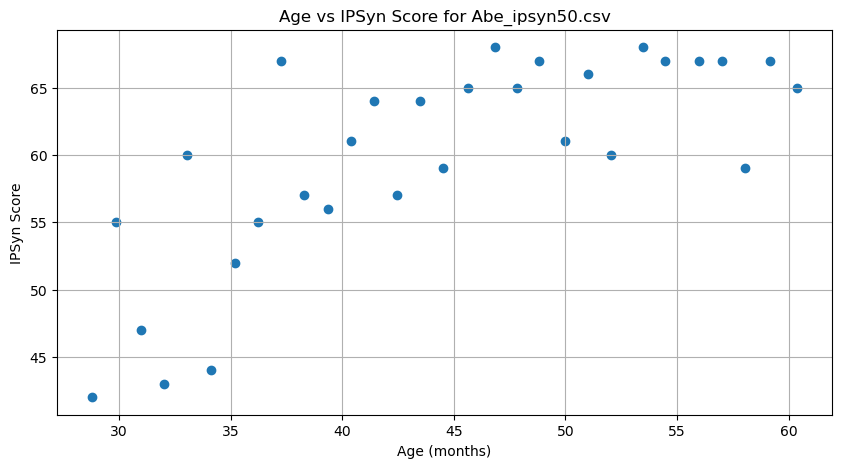

Spearman's rho for Abe_ipsyn50.csv: 0.7353

Chosen Transcripts for Abe_ipsyn50.csv: 
 ['020424.cha', '020526.cha', '020700.cha', '020801.cha', '020901.cha', '021003.cha', '021106.cha', '030007.cha', '030108.cha', '030209.cha', '030311.cha', '030412.cha', '030513.cha', '030613.cha', '030715.cha', '030816.cha', '030919.cha', '031025.cha', '031125.cha', '040025.cha', '040129.cha', '040301.cha', '040401.cha', '040514.cha', '040614.cha', '040800.cha', '040900.cha', '041001.cha', '041105.cha', '050011.cha'] 

IPSyn Scores for Abe_ipsyn50.csv: 
 [42.0, 55.0, 47.0, 43.0, 60.0, 44.0, 52.0, 55.0, 67.0, 57.0, 56.0, 61.0, 64.0, 57.0, 64.0, 59.0, 65.0, 68.0, 65.0, 67.0, 61.0, 66.0, 60.0, 68.0, 67.0, 67.0, 67.0, 59.0, 67.0, 65.0] 

Ages for Abe_ipsyn50.csv: 
 [28.8, 29.866666666666667, 31.0, 32.03333333333333, 33.03333333333333, 34.1, 35.2, 36.233333333333334, 37.266666666666666, 38.3, 39.36666666666667, 40.4, 41.43333333333334, 42.43333333333334, 43.5, 44.53333333333333, 45.63333333333333, 46.83333

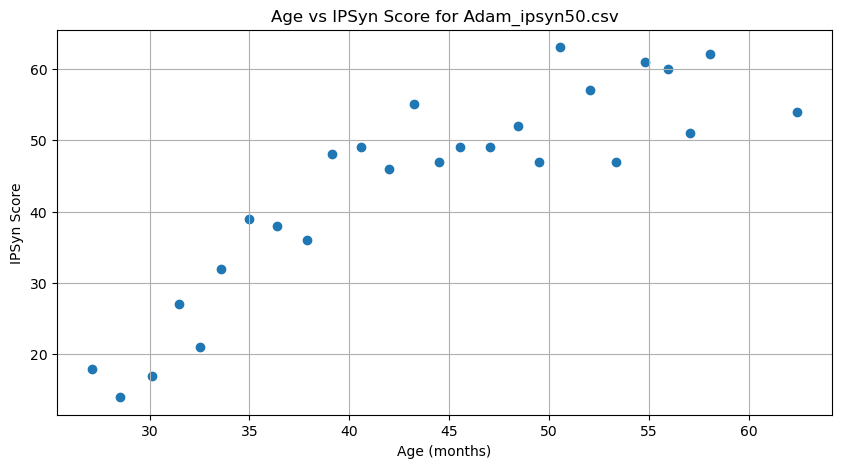

Spearman's rho for Adam_ipsyn50.csv: 0.8699

Chosen Transcripts for Adam_ipsyn50.csv: 
 ['020304.cha', '020415.cha', '020603.cha', '020714.cha', '020816.cha', '020918.cha', '021030.cha', '030011.cha', '030126.cha', '030304.cha', '030418.cha', '030529.cha', '030707.cha', '030814.cha', '030916.cha', '031101.cha', '040014.cha', '040115.cha', '040217.cha', '040401.cha', '040511.cha', '040624.cha', '040729.cha', '040902.cha', '041002.cha', '050212.cha'] 

IPSyn Scores for Adam_ipsyn50.csv: 
 [18.0, 14.0, 17.0, 27.0, 21.0, 32.0, 39.0, 38.0, 36.0, 48.0, 49.0, 46.0, 55.0, 47.0, 49.0, 49.0, 52.0, 47.0, 63.0, 57.0, 47.0, 61.0, 60.0, 51.0, 62.0, 54.0] 

Ages for Adam_ipsyn50.csv: 
 [27.133333333333333, 28.5, 30.1, 31.46666666666667, 32.53333333333333, 33.6, 35.0, 36.36666666666667, 37.86666666666667, 39.13333333333333, 40.6, 41.96666666666667, 43.233333333333334, 44.46666666666667, 45.53333333333333, 47.03333333333333, 48.46666666666667, 49.5, 50.56666666666666, 52.03333333333333, 53.366666666666

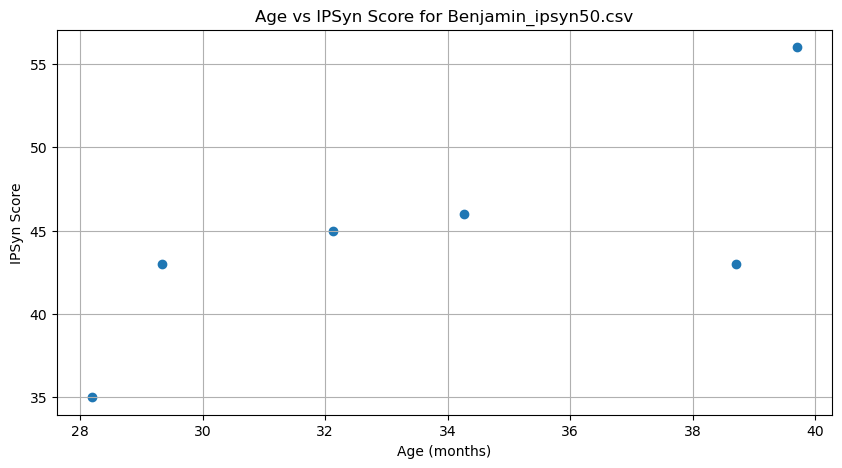

Spearman's rho for Benjamin_ipsyn50.csv: 0.7537

Chosen Transcripts for Benjamin_ipsyn50.csv: 
 ['020406.cha', '020510.cha', '020804.cha', '021008.cha', '030221.cha', '030321.cha'] 

IPSyn Scores for Benjamin_ipsyn50.csv: 
 [35.0, 43.0, 45.0, 46.0, 43.0, 56.0] 

Ages for Benjamin_ipsyn50.csv: 
 [28.2, 29.333333333333332, 32.13333333333333, 34.266666666666666, 38.7, 39.7] 

Time Steps for Benjamin_ipsyn50.csv: 
 [1.1333333333333329, 2.8000000000000007, 2.133333333333333, 4.433333333333337, 1.0] 



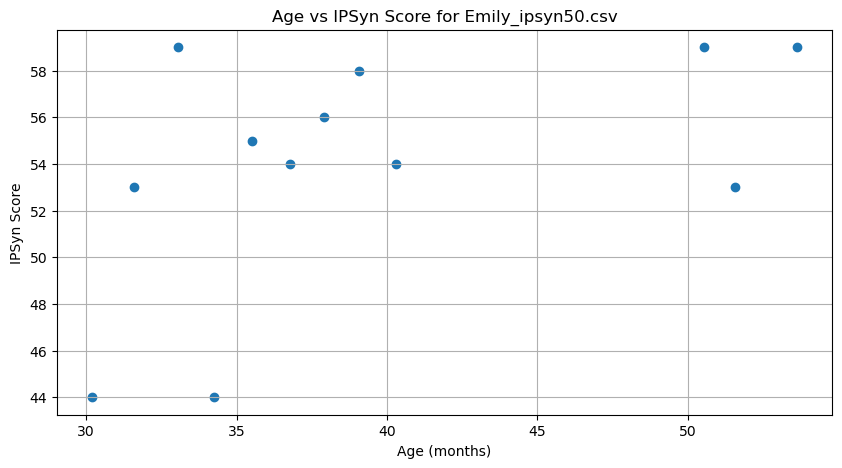

Spearman's rho for Emily_ipsyn50.csv: 0.4708

Chosen Transcripts for Emily_ipsyn50.csv: 
 ['020606.cha', '020718.cha', '020902.cha', '021007.cha', '021115.cha', '030023.cha', '030127.cha', '030302.cha', '030409.cha', '040216.cha', '040317.cha', '040519.cha'] 

IPSyn Scores for Emily_ipsyn50.csv: 
 [44.0, 53.0, 59.0, 44.0, 55.0, 54.0, 56.0, 58.0, 54.0, 59.0, 53.0, 59.0] 

Ages for Emily_ipsyn50.csv: 
 [30.2, 31.6, 33.06666666666666, 34.233333333333334, 35.5, 36.766666666666666, 37.9, 39.06666666666667, 40.3, 50.53333333333333, 51.56666666666666, 53.63333333333333] 

Time Steps for Emily_ipsyn50.csv: 
 [1.4000000000000021, 1.4666666666666615, 1.1666666666666714, 1.2666666666666657, 1.2666666666666657, 1.1333333333333329, 1.1666666666666714, 1.2333333333333272, 10.233333333333334, 1.0333333333333314, 2.06666666666667] 



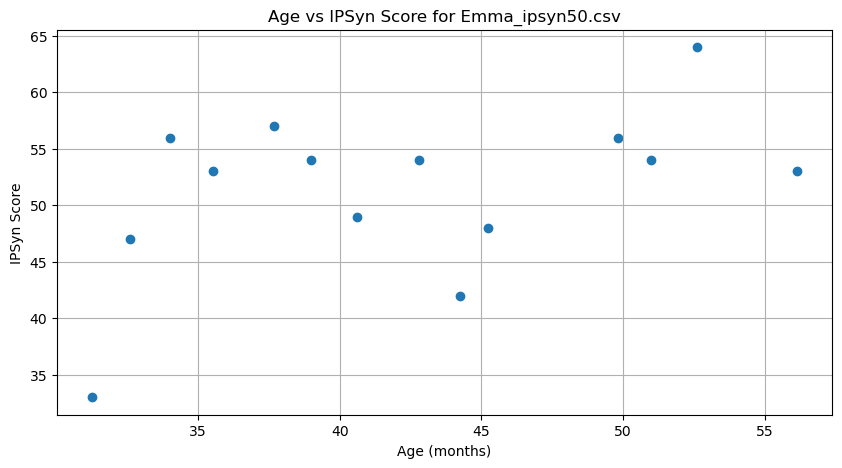

Spearman's rho for Emma_ipsyn50.csv: 0.3164

Chosen Transcripts for Emma_ipsyn50.csv: 
 ['020708.cha', '020818.cha', '021000.cha', '021116.cha', '030120.cha', '030300.cha', '030418.cha', '030624.cha', '030807.cha', '030907.cha', '040125.cha', '040300.cha', '040418.cha', '040804.cha'] 

IPSyn Scores for Emma_ipsyn50.csv: 
 [33.0, 47.0, 56.0, 53.0, 57.0, 54.0, 49.0, 54.0, 42.0, 48.0, 56.0, 54.0, 64.0, 53.0] 

Ages for Emma_ipsyn50.csv: 
 [31.266666666666666, 32.6, 34.0, 35.53333333333333, 37.666666666666664, 39.0, 40.6, 42.8, 44.233333333333334, 45.233333333333334, 49.833333333333336, 51.0, 52.6, 56.13333333333333] 

Time Steps for Emma_ipsyn50.csv: 
 [1.3333333333333357, 1.3999999999999986, 1.5333333333333314, 2.133333333333333, 1.3333333333333357, 1.6000000000000014, 2.1999999999999957, 1.4333333333333371, 1.0, 4.600000000000001, 1.1666666666666643, 1.6000000000000014, 3.5333333333333314] 



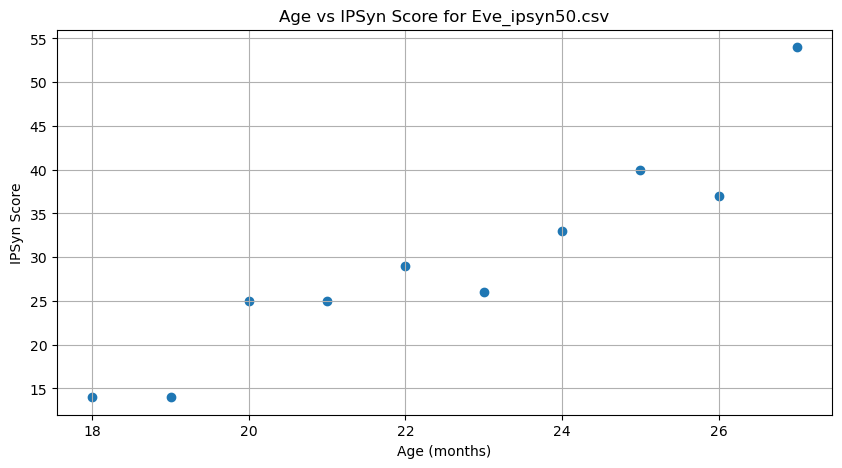

Spearman's rho for Eve_ipsyn50.csv: 0.9695

Chosen Transcripts for Eve_ipsyn50.csv: 
 ['010600a.cha', '010700a.cha', '010800.cha', '010900a.cha', '011000a.cha', '011100a.cha', '020000a.cha', '020100a.cha', '020200a.cha', '020300a.cha'] 

IPSyn Scores for Eve_ipsyn50.csv: 
 [14.0, 14.0, 25.0, 25.0, 29.0, 26.0, 33.0, 40.0, 37.0, 54.0] 

Ages for Eve_ipsyn50.csv: 
 [18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0] 

Time Steps for Eve_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



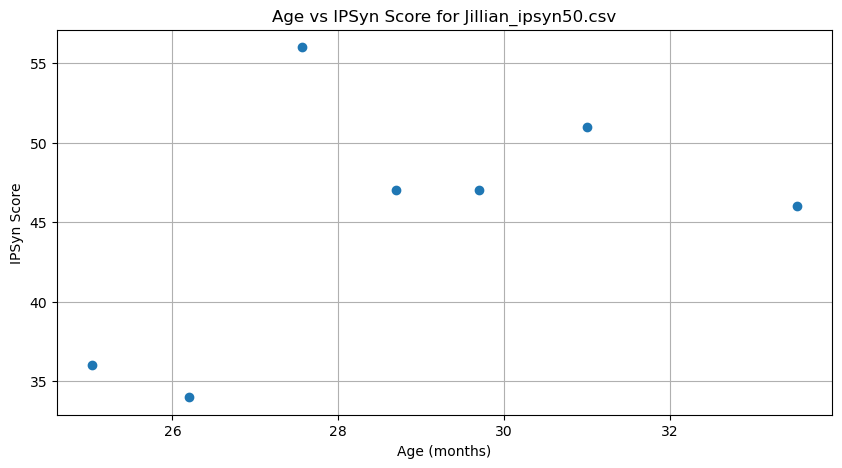

Spearman's rho for Jillian_ipsyn50.csv: 0.3784

Chosen Transcripts for Jillian_ipsyn50.csv: 
 ['020101.cha', '020206.cha', '020317.cha', '020421.cha', '020521.cha', '020700.cha', '020916.cha'] 

IPSyn Scores for Jillian_ipsyn50.csv: 
 [36.0, 34.0, 56.0, 47.0, 47.0, 51.0, 46.0] 

Ages for Jillian_ipsyn50.csv: 
 [25.033333333333335, 26.2, 27.566666666666666, 28.7, 29.7, 31.0, 33.53333333333333] 

Time Steps for Jillian_ipsyn50.csv: 
 [1.1666666666666643, 1.3666666666666671, 1.1333333333333329, 1.0, 1.3000000000000007, 2.5333333333333314] 



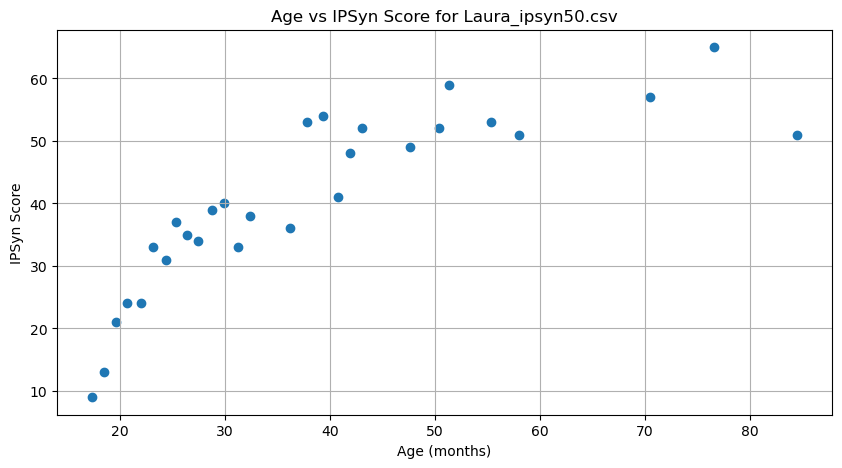

Spearman's rho for Laura_ipsyn50.csv: 0.9051

Chosen Transcripts for Laura_ipsyn50.csv: 
 ['010510.cha', '010614a.cha', '010717.cha', '010819.cha', '011000.cha', '011103.cha', '020010.cha', '020110.cha', '020212b.cha', '020312.cha', '020423.cha', '020526.cha', '020708.cha', '020811.cha', '030006.cha', '030125a.cha', '030311.cha', '030422.cha', '030528a.cha', '030700.cha', '031117.cha', '040211b.cha', '040311b.cha', '040711a.cha', '041000.cha', '051013.cha', '060417.cha', '070014.cha'] 

IPSyn Scores for Laura_ipsyn50.csv: 
 [9.0, 13.0, 21.0, 24.0, 24.0, 33.0, 31.0, 37.0, 35.0, 34.0, 39.0, 40.0, 33.0, 38.0, 36.0, 53.0, 54.0, 41.0, 48.0, 52.0, 49.0, 52.0, 59.0, 53.0, 51.0, 57.0, 65.0, 51.0] 

Ages for Laura_ipsyn50.csv: 
 [17.333333333333332, 18.46666666666667, 19.566666666666666, 20.633333333333333, 22.0, 23.1, 24.333333333333332, 25.333333333333332, 26.4, 27.4, 28.766666666666666, 29.866666666666667, 31.266666666666666, 32.36666666666667, 36.2, 37.833333333333336, 39.36666666666667, 40

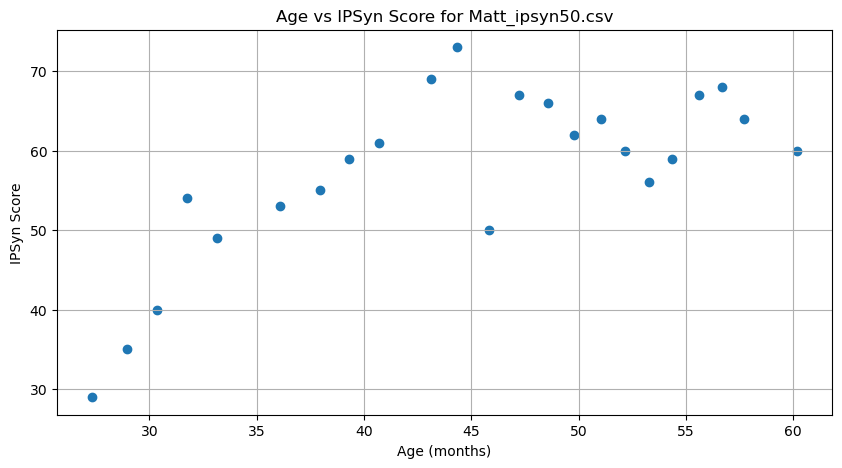

Spearman's rho for Matt_ipsyn50.csv: 0.6281

Chosen Transcripts for Matt_ipsyn50.csv: 
 ['020310.cha', '020428.cha', '020611.cha', '020722.cha', '020905.cha', '030002.cha', '030129.cha', '030309.cha', '030421.cha', '030704.cha', '030810.cha', '030924.cha', '031106.cha', '040017.cha', '040123.cha', '040301.cha', '040405.cha', '040509.cha', '040610.cha', '040718.cha', '040821.cha', '040921.cha', '050005.cha'] 

IPSyn Scores for Matt_ipsyn50.csv: 
 [29.0, 35.0, 40.0, 54.0, 49.0, 53.0, 55.0, 59.0, 61.0, 69.0, 73.0, 50.0, 67.0, 66.0, 62.0, 64.0, 60.0, 56.0, 59.0, 67.0, 68.0, 64.0, 60.0] 

Ages for Matt_ipsyn50.csv: 
 [27.333333333333332, 28.933333333333334, 30.366666666666667, 31.733333333333334, 33.166666666666664, 36.06666666666667, 37.96666666666667, 39.3, 40.7, 43.13333333333333, 44.333333333333336, 45.8, 47.2, 48.56666666666667, 49.766666666666666, 51.03333333333333, 52.166666666666664, 53.3, 54.333333333333336, 55.6, 56.7, 57.7, 60.166666666666664] 

Time Steps for Matt_ipsyn50.csv: 


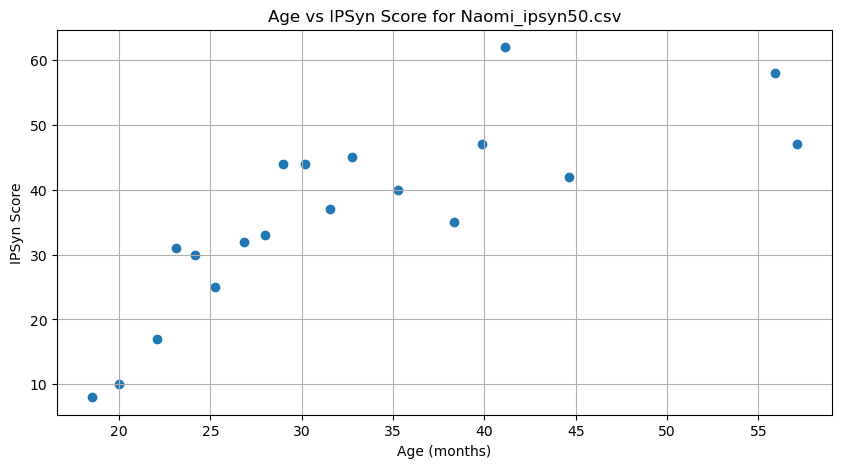

Spearman's rho for Naomi_ipsyn50.csv: 0.8929

Chosen Transcripts for Naomi_ipsyn50.csv: 
 ['010616.cha', '010800.cha', '011003.cha', '011103.cha', '020005.cha', '020107.cha', '020225.cha', '020329.cha', '020430.cha', '020605.cha', '020716.cha', '020823.cha', '021108.cha', '030210.cha', '030326.cha', '030503.cha', '030819.cha', '040728.cha', '040903.cha'] 

IPSyn Scores for Naomi_ipsyn50.csv: 
 [8.0, 10.0, 17.0, 31.0, 30.0, 25.0, 32.0, 33.0, 44.0, 44.0, 37.0, 45.0, 40.0, 35.0, 47.0, 62.0, 42.0, 58.0, 47.0] 

Ages for Naomi_ipsyn50.csv: 
 [18.53333333333333, 20.0, 22.1, 23.1, 24.166666666666668, 25.233333333333334, 26.833333333333332, 27.96666666666667, 29.0, 30.166666666666668, 31.53333333333333, 32.766666666666666, 35.266666666666666, 38.333333333333336, 39.86666666666667, 41.1, 44.63333333333333, 55.93333333333334, 57.1] 

Time Steps for Naomi_ipsyn50.csv: 
 [1.4666666666666686, 2.1000000000000014, 1.0, 1.0666666666666664, 1.0666666666666664, 1.5999999999999979, 1.1333333333333364, 1.

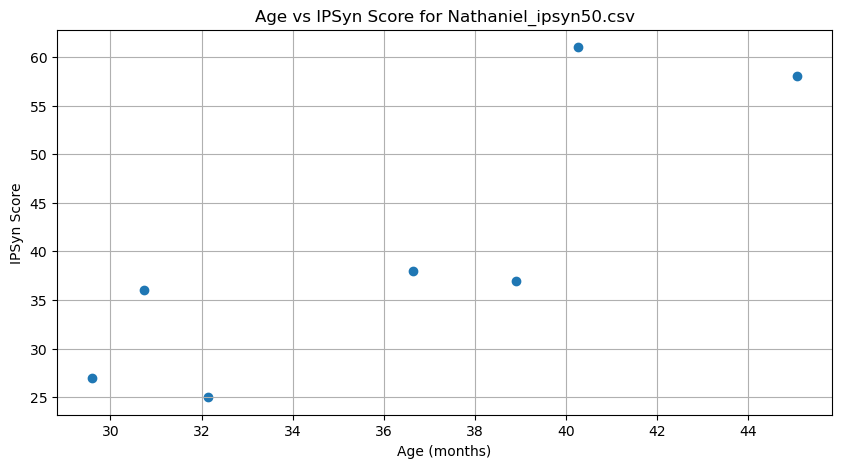

Spearman's rho for Nathaniel_ipsyn50.csv: 0.8214

Chosen Transcripts for Nathaniel_ipsyn50.csv: 
 ['020518a.cha', '020622a.cha', '020804a.cha', '030019b.cha', '030227a.cha', '030408a.cha', '030902.cha'] 

IPSyn Scores for Nathaniel_ipsyn50.csv: 
 [27.0, 36.0, 25.0, 38.0, 37.0, 61.0, 58.0] 

Ages for Nathaniel_ipsyn50.csv: 
 [29.6, 30.733333333333334, 32.13333333333333, 36.63333333333333, 38.9, 40.266666666666666, 45.06666666666666] 

Time Steps for Nathaniel_ipsyn50.csv: 
 [1.1333333333333329, 1.3999999999999986, 4.5, 2.2666666666666657, 1.3666666666666671, 4.799999999999997] 



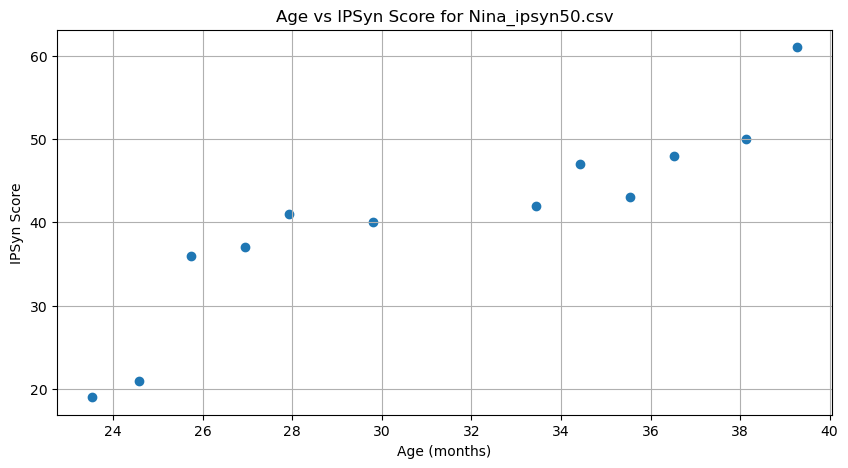

Spearman's rho for Nina_ipsyn50.csv: 0.9860

Chosen Transcripts for Nina_ipsyn50.csv: 
 ['011116.cha', '020017.cha', '020122.cha', '020228.cha', '020328.cha', '020524.cha', '020913.cha', '021013.cha', '021116.cha', '030016.cha', '030204.cha', '030308.cha'] 

IPSyn Scores for Nina_ipsyn50.csv: 
 [19.0, 21.0, 36.0, 37.0, 41.0, 40.0, 42.0, 47.0, 43.0, 48.0, 50.0, 61.0] 

Ages for Nina_ipsyn50.csv: 
 [23.53333333333333, 24.566666666666666, 25.733333333333334, 26.933333333333334, 27.933333333333334, 29.8, 33.43333333333334, 34.43333333333334, 35.53333333333333, 36.53333333333333, 38.13333333333333, 39.266666666666666] 

Time Steps for Nina_ipsyn50.csv: 
 [1.033333333333335, 1.1666666666666679, 1.1999999999999993, 1.0, 1.8666666666666671, 3.6333333333333364, 1.0, 1.0999999999999943, 1.0, 1.6000000000000014, 1.1333333333333329] 



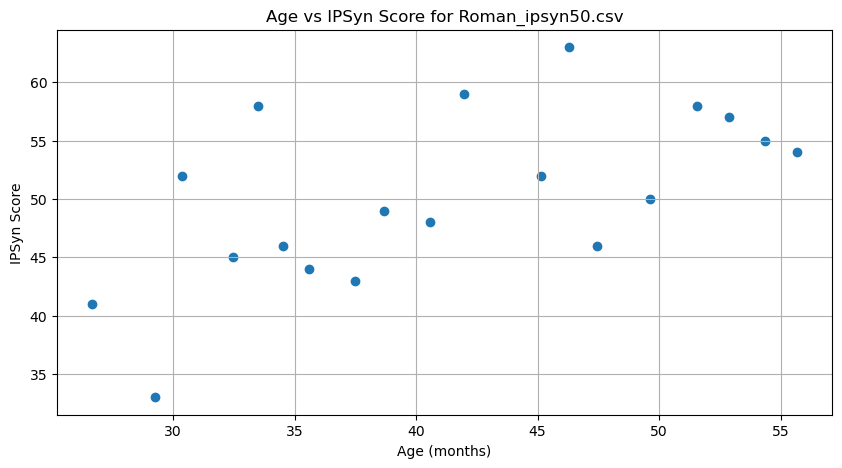

Spearman's rho for Roman_ipsyn50.csv: 0.5885

Chosen Transcripts for Roman_ipsyn50.csv: 
 ['020220.cha', '020507.cha', '020611.cha', '020814.cha', '020915.cha', '021015.cha', '021118.cha', '030114.cha', '030220.cha', '030417.cha', '030529.cha', '030904.cha', '031009.cha', '031113.cha', '040119.cha', '040317.cha', '040426.cha', '040611.cha', '040720.cha'] 

IPSyn Scores for Roman_ipsyn50.csv: 
 [41.0, 33.0, 52.0, 45.0, 58.0, 46.0, 44.0, 43.0, 49.0, 48.0, 59.0, 52.0, 63.0, 46.0, 50.0, 58.0, 57.0, 55.0, 54.0] 

Ages for Roman_ipsyn50.csv: 
 [26.666666666666668, 29.233333333333334, 30.366666666666667, 32.46666666666667, 33.5, 34.5, 35.6, 37.46666666666667, 38.666666666666664, 40.56666666666666, 41.96666666666667, 45.13333333333333, 46.3, 47.43333333333334, 49.63333333333333, 51.56666666666666, 52.86666666666667, 54.36666666666667, 55.666666666666664] 

Time Steps for Roman_ipsyn50.csv: 
 [2.5666666666666664, 1.1333333333333329, 2.1000000000000014, 1.0333333333333314, 1.0, 1.100000000000001

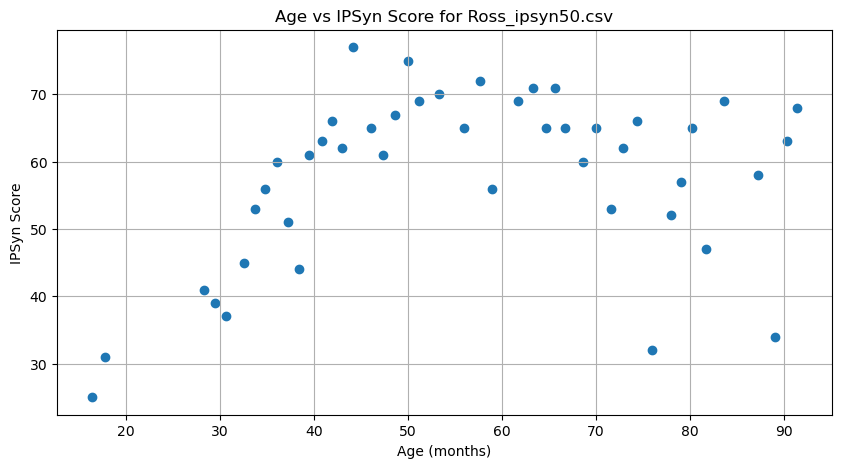

Spearman's rho for Ross_ipsyn50.csv: 0.2931

Chosen Transcripts for Ross_ipsyn50.csv: 
 ['010411a.cha', '010523.cha', '020409.cha', '020514a.cha', '020617a.cha', '020817b.cha', '020921.cha', '021022a.cha', '030001a.cha', '030105a.cha', '030213a.cha', '030315a.cha', '030426a.cha', '030526a.cha', '030628.cha', '030803a.cha', '031001.cha', '031109.cha', '040019.cha', '040201.cha', '040305a.cha', '040508a.cha', '040800a.cha', '040920a.cha', '041027a.cha', '050120a.cha', '050309a.cha', '050420a.cha', '050520a.cha', '050622a.cha', '050820a.cha', '051001b.cha', '051117a.cha', '060027b.cha', '060211a2.cha', '060328.cha', '060530b.cha', '060701a.cha', '060807a.cha', '060922a.cha', '061119b.cha', '070309a.cha', '070503a.cha', '070600b.cha', '070712.cha'] 

IPSyn Scores for Ross_ipsyn50.csv: 
 [25.0, 31.0, 41.0, 39.0, 37.0, 45.0, 53.0, 56.0, 60.0, 51.0, 44.0, 61.0, 63.0, 66.0, 62.0, 77.0, 65.0, 61.0, 67.0, 75.0, 69.0, 70.0, 65.0, 72.0, 56.0, 69.0, 71.0, 65.0, 71.0, 65.0, 60.0, 65.0, 53.0, 62.0, 6

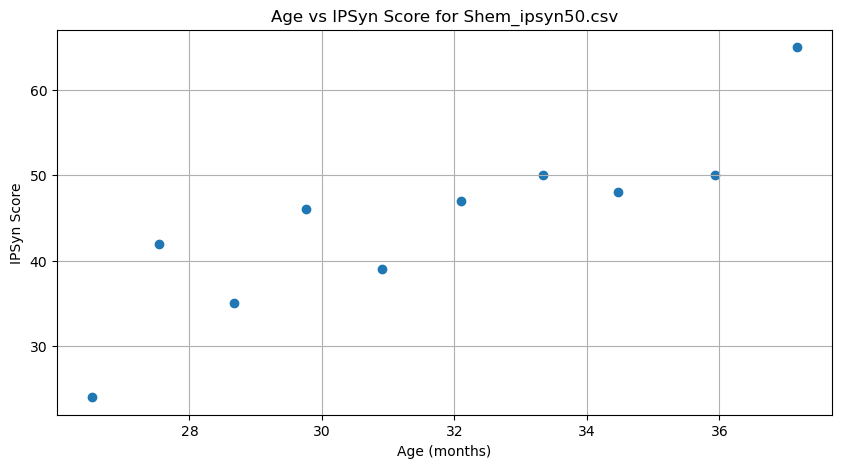

Spearman's rho for Shem_ipsyn50.csv: 0.9179

Chosen Transcripts for Shem_ipsyn50.csv: 
 ['020216.cha', '020316.cha', '020420.cha', '020523.cha', '020627.cha', '020803.cha', '020910.cha', '021014.cha', '021128.cha', '030105.cha'] 

IPSyn Scores for Shem_ipsyn50.csv: 
 [24.0, 42.0, 35.0, 46.0, 39.0, 47.0, 50.0, 48.0, 50.0, 65.0] 

Ages for Shem_ipsyn50.csv: 
 [26.53333333333333, 27.53333333333333, 28.666666666666668, 29.766666666666666, 30.9, 32.1, 33.333333333333336, 34.46666666666667, 35.93333333333334, 37.166666666666664] 

Time Steps for Shem_ipsyn50.csv: 
 [1.0, 1.1333333333333364, 1.0999999999999979, 1.1333333333333329, 1.2000000000000028, 1.2333333333333343, 1.1333333333333329, 1.4666666666666686, 1.2333333333333272] 



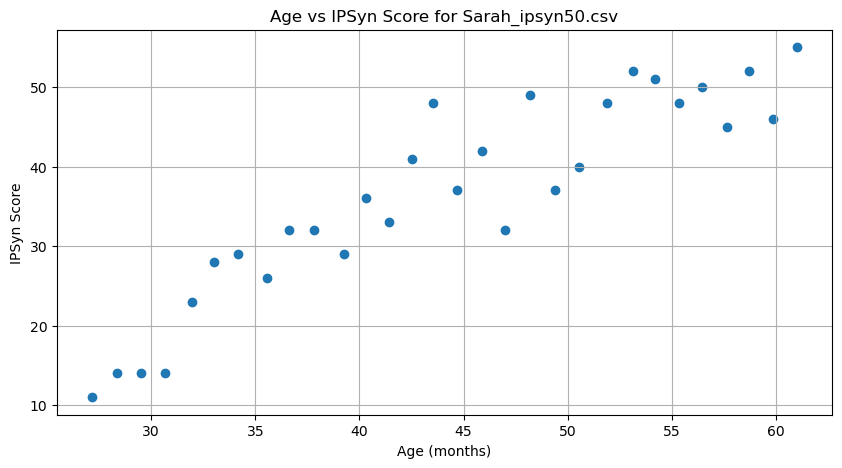

Spearman's rho for Sarah_ipsyn50.csv: 0.9137

Chosen Transcripts for Sarah_ipsyn50.csv: 
 ['020305.cha', '020410.cha', '020515.cha', '020620.cha', '020728.cha', '020900.cha', '021005.cha', '021117.cha', '030018a.cha', '030124.cha', '030307a.cha', '030409.cha', '030513.cha', '030616.cha', '030716.cha', '030820.cha', '030926a.cha', '031030.cha', '040005.cha', '040111.cha', '040216.cha', '040326.cha', '040504.cha', '040605.cha', '040711.cha', '040813.cha', '040919.cha', '041021.cha', '041126.cha', '050030.cha'] 

IPSyn Scores for Sarah_ipsyn50.csv: 
 [11.0, 14.0, 14.0, 14.0, 23.0, 28.0, 29.0, 26.0, 32.0, 32.0, 29.0, 36.0, 33.0, 41.0, 48.0, 37.0, 42.0, 32.0, 49.0, 37.0, 40.0, 48.0, 52.0, 51.0, 48.0, 50.0, 45.0, 52.0, 46.0, 55.0] 

Ages for Sarah_ipsyn50.csv: 
 [27.166666666666668, 28.333333333333332, 29.5, 30.666666666666668, 31.933333333333334, 33.0, 34.166666666666664, 35.56666666666666, 36.6, 37.8, 39.233333333333334, 40.3, 41.43333333333334, 42.53333333333333, 43.53333333333333, 44.666

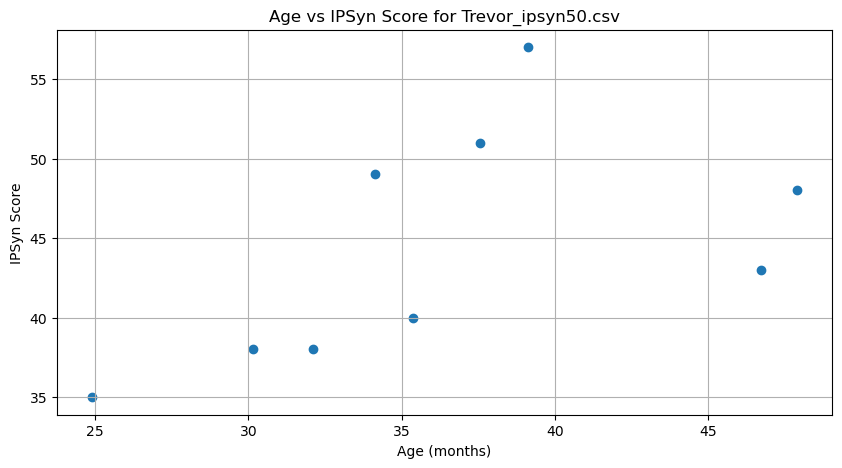

Spearman's rho for Trevor_ipsyn50.csv: 0.6946

Chosen Transcripts for Trevor_ipsyn50.csv: 
 ['020027.cha', '020604.cha', '020803.cha', '021004.cha', '021111.cha', '030117.cha', '030304.cha', '031022.cha', '031127a.cha'] 

IPSyn Scores for Trevor_ipsyn50.csv: 
 [35.0, 38.0, 38.0, 49.0, 40.0, 51.0, 57.0, 43.0, 48.0] 

Ages for Trevor_ipsyn50.csv: 
 [24.9, 30.133333333333333, 32.1, 34.13333333333333, 35.36666666666667, 37.56666666666667, 39.13333333333333, 46.733333333333334, 47.9] 

Time Steps for Trevor_ipsyn50.csv: 
 [5.233333333333334, 1.9666666666666686, 2.0333333333333314, 1.2333333333333343, 2.200000000000003, 1.5666666666666629, 7.600000000000001, 1.1666666666666643] 



In [5]:
age_ipsyn_plots(ipsyn_files_50, spearman_rhos_50, age_files)

## Age vs IPSyn Score (100 Utterances)

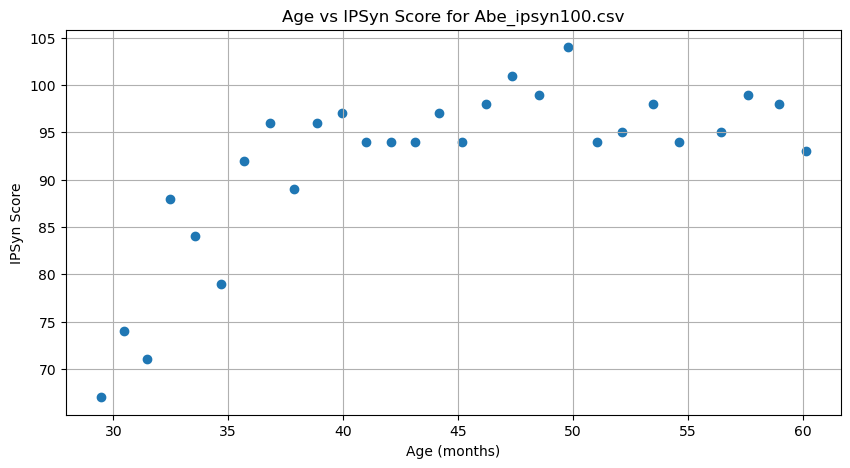

Spearman's rho for Abe_ipsyn100.csv: 0.6585

Chosen Transcripts for Abe_ipsyn100.csv: 
 ['020514.cha', '020614a.cha', '020714.cha', '020814.cha', '020916.cha', '021020.cha', '021121.cha', '030025.cha', '030126.cha', '030226.cha', '030328.cha', '030430.cha', '030603.cha', '030704.cha', '030805.cha', '030905.cha', '031007.cha', '031111.cha', '040016.cha', '040124.cha', '040301.cha', '040404.cha', '040514.cha', '040619.cha', '040814.cha', '040919.cha', '041029.cha', '050004.cha'] 

IPSyn Scores for Abe_ipsyn100.csv: 
 [67.0, 74.0, 71.0, 88.0, 84.0, 79.0, 92.0, 96.0, 89.0, 96.0, 97.0, 94.0, 94.0, 94.0, 97.0, 94.0, 98.0, 101.0, 99.0, 104.0, 94.0, 95.0, 98.0, 94.0, 95.0, 99.0, 98.0, 93.0] 

Ages for Abe_ipsyn100.csv: 
 [29.46666666666667, 30.46666666666667, 31.46666666666667, 32.46666666666667, 33.53333333333333, 34.666666666666664, 35.7, 36.833333333333336, 37.86666666666667, 38.86666666666667, 39.93333333333334, 41.0, 42.1, 43.13333333333333, 44.166666666666664, 45.166666666666664, 46.2333

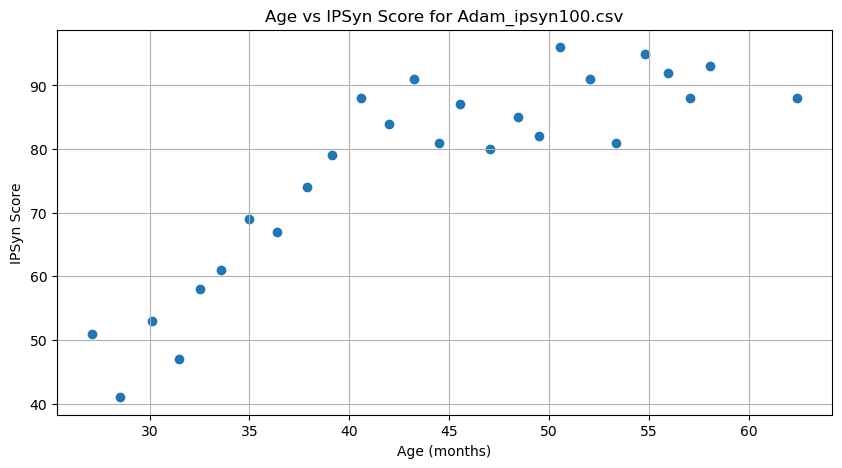

Spearman's rho for Adam_ipsyn100.csv: 0.8587

Chosen Transcripts for Adam_ipsyn100.csv: 
 ['020304.cha', '020415.cha', '020603.cha', '020714.cha', '020816.cha', '020918.cha', '021030.cha', '030011.cha', '030126.cha', '030304.cha', '030418.cha', '030529.cha', '030707.cha', '030814.cha', '030916.cha', '031101.cha', '040014.cha', '040115.cha', '040217.cha', '040401.cha', '040511.cha', '040624.cha', '040729.cha', '040902.cha', '041002.cha', '050212.cha'] 

IPSyn Scores for Adam_ipsyn100.csv: 
 [51.0, 41.0, 53.0, 47.0, 58.0, 61.0, 69.0, 67.0, 74.0, 79.0, 88.0, 84.0, 91.0, 81.0, 87.0, 80.0, 85.0, 82.0, 96.0, 91.0, 81.0, 95.0, 92.0, 88.0, 93.0, 88.0] 

Ages for Adam_ipsyn100.csv: 
 [27.133333333333333, 28.5, 30.1, 31.46666666666667, 32.53333333333333, 33.6, 35.0, 36.36666666666667, 37.86666666666667, 39.13333333333333, 40.6, 41.96666666666667, 43.233333333333334, 44.46666666666667, 45.53333333333333, 47.03333333333333, 48.46666666666667, 49.5, 50.56666666666666, 52.03333333333333, 53.36666666

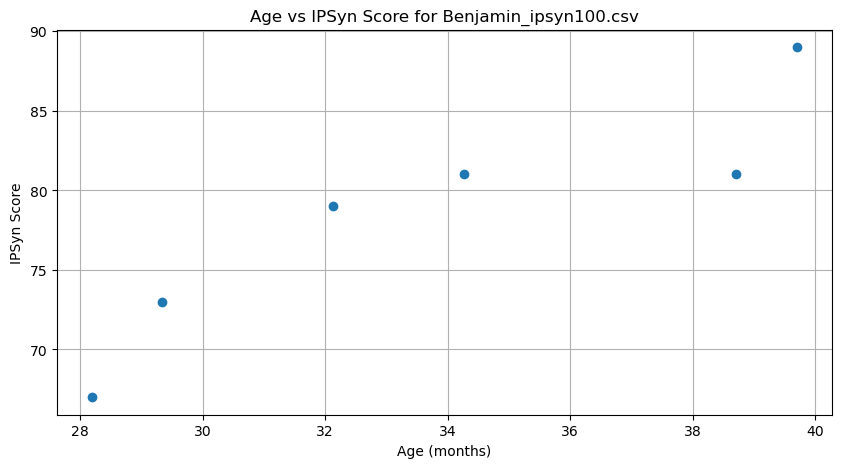

Spearman's rho for Benjamin_ipsyn100.csv: 0.9856

Chosen Transcripts for Benjamin_ipsyn100.csv: 
 ['020406.cha', '020510.cha', '020804.cha', '021008.cha', '030221.cha', '030321.cha'] 

IPSyn Scores for Benjamin_ipsyn100.csv: 
 [67.0, 73.0, 79.0, 81.0, 81.0, 89.0] 

Ages for Benjamin_ipsyn100.csv: 
 [28.2, 29.333333333333332, 32.13333333333333, 34.266666666666666, 38.7, 39.7] 

Time Steps for Benjamin_ipsyn100.csv: 
 [1.1333333333333329, 2.8000000000000007, 2.133333333333333, 4.433333333333337, 1.0] 



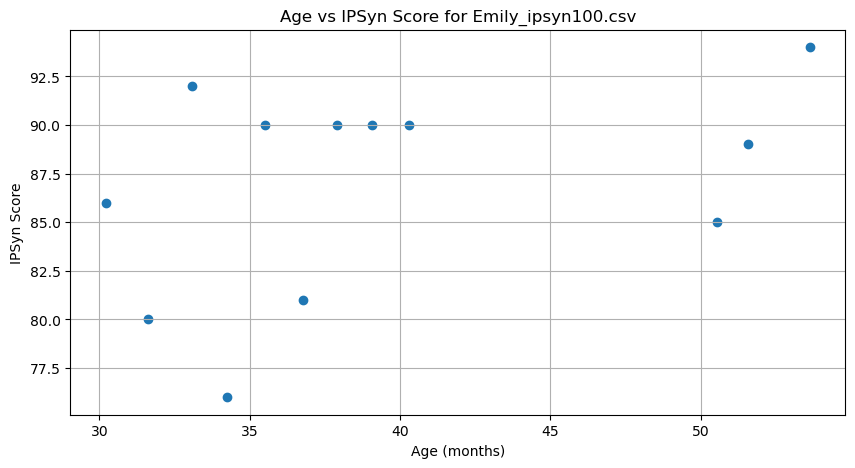

Spearman's rho for Emily_ipsyn100.csv: 0.3808

Chosen Transcripts for Emily_ipsyn100.csv: 
 ['020606.cha', '020718.cha', '020902.cha', '021007.cha', '021115.cha', '030023.cha', '030127.cha', '030302.cha', '030409.cha', '040216.cha', '040317.cha', '040519.cha'] 

IPSyn Scores for Emily_ipsyn100.csv: 
 [86.0, 80.0, 92.0, 76.0, 90.0, 81.0, 90.0, 90.0, 90.0, 85.0, 89.0, 94.0] 

Ages for Emily_ipsyn100.csv: 
 [30.2, 31.6, 33.06666666666666, 34.233333333333334, 35.5, 36.766666666666666, 37.9, 39.06666666666667, 40.3, 50.53333333333333, 51.56666666666666, 53.63333333333333] 

Time Steps for Emily_ipsyn100.csv: 
 [1.4000000000000021, 1.4666666666666615, 1.1666666666666714, 1.2666666666666657, 1.2666666666666657, 1.1333333333333329, 1.1666666666666714, 1.2333333333333272, 10.233333333333334, 1.0333333333333314, 2.06666666666667] 



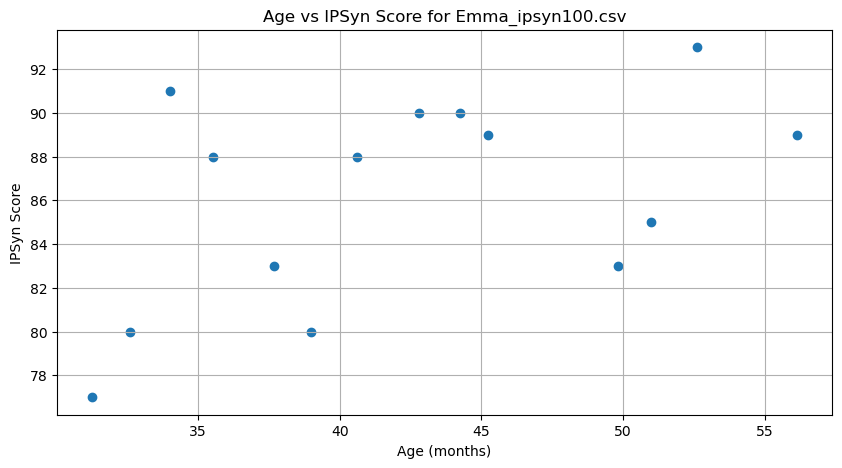

Spearman's rho for Emma_ipsyn100.csv: 0.4619

Chosen Transcripts for Emma_ipsyn100.csv: 
 ['020708.cha', '020818.cha', '021000.cha', '021116.cha', '030120.cha', '030300.cha', '030418.cha', '030624.cha', '030807.cha', '030907.cha', '040125.cha', '040300.cha', '040418.cha', '040804.cha'] 

IPSyn Scores for Emma_ipsyn100.csv: 
 [77.0, 80.0, 91.0, 88.0, 83.0, 80.0, 88.0, 90.0, 90.0, 89.0, 83.0, 85.0, 93.0, 89.0] 

Ages for Emma_ipsyn100.csv: 
 [31.266666666666666, 32.6, 34.0, 35.53333333333333, 37.666666666666664, 39.0, 40.6, 42.8, 44.233333333333334, 45.233333333333334, 49.833333333333336, 51.0, 52.6, 56.13333333333333] 

Time Steps for Emma_ipsyn100.csv: 
 [1.3333333333333357, 1.3999999999999986, 1.5333333333333314, 2.133333333333333, 1.3333333333333357, 1.6000000000000014, 2.1999999999999957, 1.4333333333333371, 1.0, 4.600000000000001, 1.1666666666666643, 1.6000000000000014, 3.5333333333333314] 



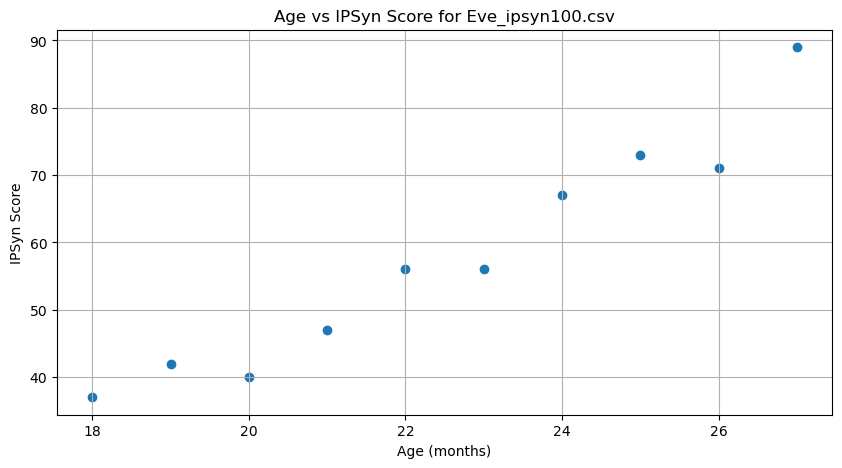

Spearman's rho for Eve_ipsyn100.csv: 0.9726

Chosen Transcripts for Eve_ipsyn100.csv: 
 ['010600a.cha', '010700a.cha', '010800.cha', '010900a.cha', '011000a.cha', '011100a.cha', '020000a.cha', '020100a.cha', '020200a.cha', '020300a.cha'] 

IPSyn Scores for Eve_ipsyn100.csv: 
 [37.0, 42.0, 40.0, 47.0, 56.0, 56.0, 67.0, 73.0, 71.0, 89.0] 

Ages for Eve_ipsyn100.csv: 
 [18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0] 

Time Steps for Eve_ipsyn100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



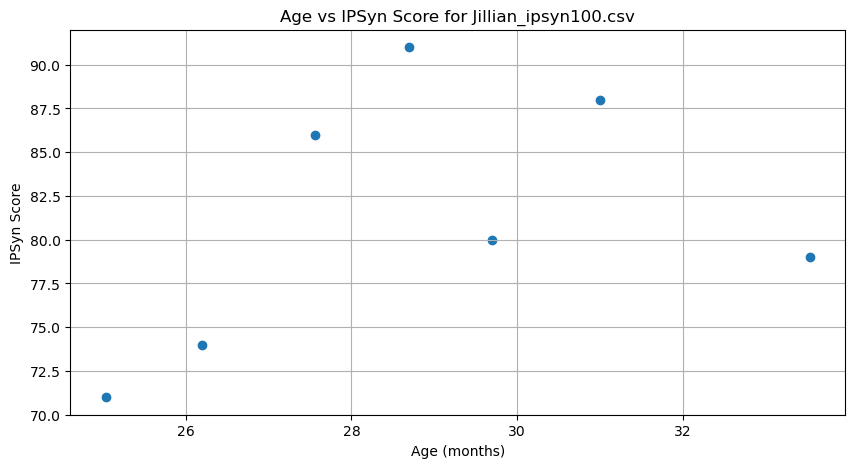

Spearman's rho for Jillian_ipsyn100.csv: 0.4643

Chosen Transcripts for Jillian_ipsyn100.csv: 
 ['020101.cha', '020206.cha', '020317.cha', '020421.cha', '020521.cha', '020700.cha', '020916.cha'] 

IPSyn Scores for Jillian_ipsyn100.csv: 
 [71.0, 74.0, 86.0, 91.0, 80.0, 88.0, 79.0] 

Ages for Jillian_ipsyn100.csv: 
 [25.033333333333335, 26.2, 27.566666666666666, 28.7, 29.7, 31.0, 33.53333333333333] 

Time Steps for Jillian_ipsyn100.csv: 
 [1.1666666666666643, 1.3666666666666671, 1.1333333333333329, 1.0, 1.3000000000000007, 2.5333333333333314] 



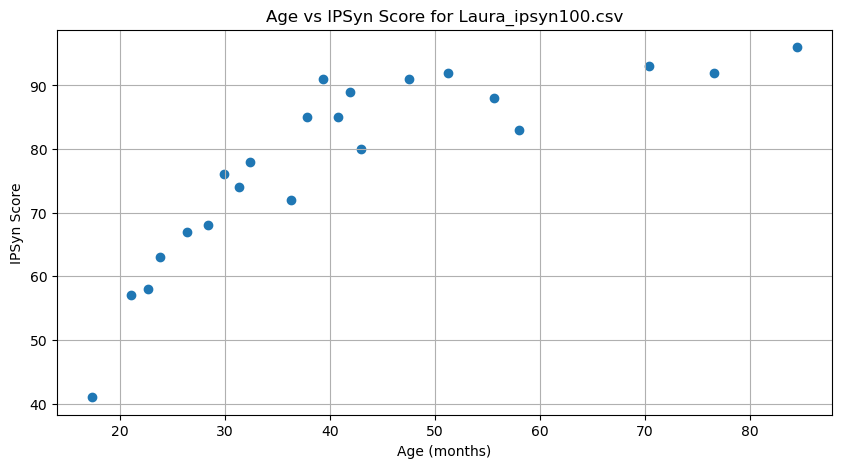

Spearman's rho for Laura_ipsyn100.csv: 0.9206

Chosen Transcripts for Laura_ipsyn100.csv: 
 ['010511.cha', '010902.cha', '011019.cha', '011124.cha', '020212b.cha', '020411.cha', '020526.cha', '020710.cha', '020811.cha', '030008.cha', '030125a.cha', '030311.cha', '030423.cha', '030528a.cha', '030700.cha', '031117.cha', '040307a.cha', '040718c.cha', '041000.cha', '051013.cha', '060417.cha', '070014.cha'] 

IPSyn Scores for Laura_ipsyn100.csv: 
 [41.0, 57.0, 58.0, 63.0, 67.0, 68.0, 76.0, 74.0, 78.0, 72.0, 85.0, 91.0, 85.0, 89.0, 80.0, 91.0, 92.0, 88.0, 83.0, 93.0, 92.0, 96.0] 

Ages for Laura_ipsyn100.csv: 
 [17.366666666666667, 21.066666666666666, 22.633333333333333, 23.8, 26.4, 28.366666666666667, 29.866666666666667, 31.333333333333332, 32.36666666666667, 36.266666666666666, 37.833333333333336, 39.36666666666667, 40.766666666666666, 41.93333333333334, 43.0, 47.56666666666666, 51.233333333333334, 55.6, 58.0, 70.43333333333334, 76.56666666666666, 84.46666666666667] 

Time Steps for Laura_

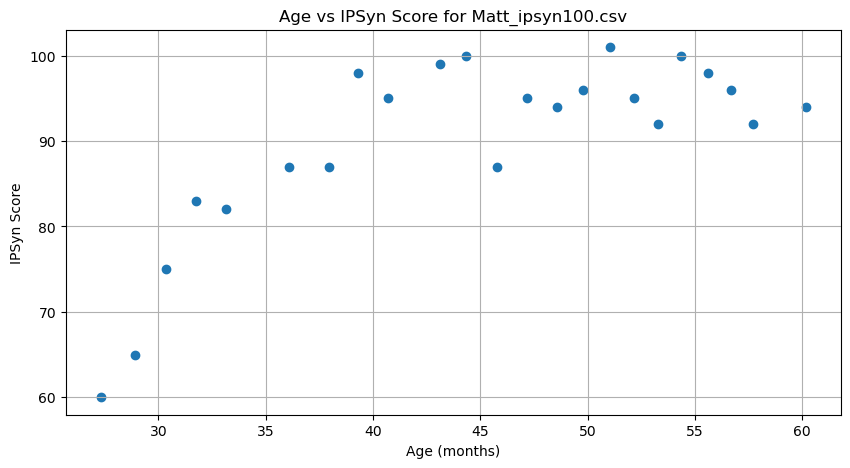

Spearman's rho for Matt_ipsyn100.csv: 0.5884

Chosen Transcripts for Matt_ipsyn100.csv: 
 ['020310.cha', '020428.cha', '020611.cha', '020722.cha', '020905.cha', '030002.cha', '030129.cha', '030309.cha', '030421.cha', '030704.cha', '030810.cha', '030924.cha', '031106.cha', '040017.cha', '040123.cha', '040301.cha', '040405.cha', '040509.cha', '040610.cha', '040718.cha', '040821.cha', '040921.cha', '050005.cha'] 

IPSyn Scores for Matt_ipsyn100.csv: 
 [60.0, 65.0, 75.0, 83.0, 82.0, 87.0, 87.0, 98.0, 95.0, 99.0, 100.0, 87.0, 95.0, 94.0, 96.0, 101.0, 95.0, 92.0, 100.0, 98.0, 96.0, 92.0, 94.0] 

Ages for Matt_ipsyn100.csv: 
 [27.333333333333332, 28.933333333333334, 30.366666666666667, 31.733333333333334, 33.166666666666664, 36.06666666666667, 37.96666666666667, 39.3, 40.7, 43.13333333333333, 44.333333333333336, 45.8, 47.2, 48.56666666666667, 49.766666666666666, 51.03333333333333, 52.166666666666664, 53.3, 54.333333333333336, 55.6, 56.7, 57.7, 60.166666666666664] 

Time Steps for Matt_ipsyn10

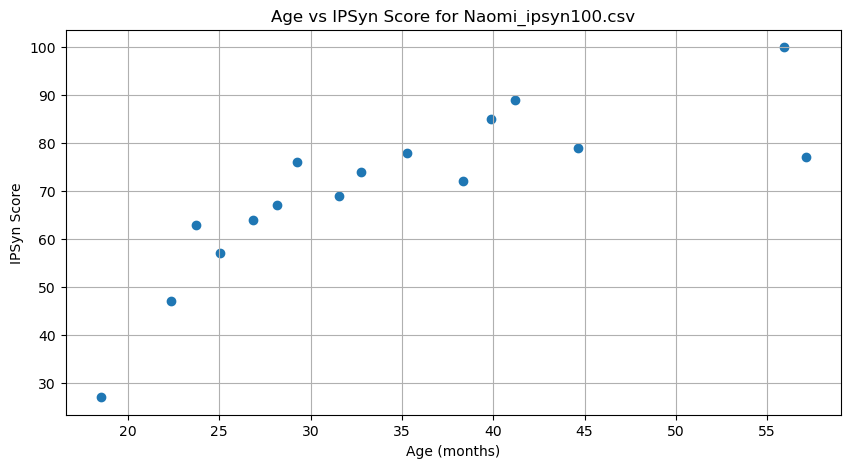

Spearman's rho for Naomi_ipsyn100.csv: 0.9118

Chosen Transcripts for Naomi_ipsyn100.csv: 
 ['010616.cha', '011010b.cha', '011121.cha', '020101.cha', '020225.cha', '020405.cha', '020508.cha', '020716.cha', '020823.cha', '021108.cha', '030210.cha', '030327.cha', '030506.cha', '030819.cha', '040728.cha', '040903.cha'] 

IPSyn Scores for Naomi_ipsyn100.csv: 
 [27.0, 47.0, 63.0, 57.0, 64.0, 67.0, 76.0, 69.0, 74.0, 78.0, 72.0, 85.0, 89.0, 79.0, 100.0, 77.0] 

Ages for Naomi_ipsyn100.csv: 
 [18.53333333333333, 22.333333333333336, 23.7, 25.033333333333335, 26.833333333333332, 28.166666666666668, 29.266666666666666, 31.53333333333333, 32.766666666666666, 35.266666666666666, 38.333333333333336, 39.9, 41.2, 44.63333333333333, 55.93333333333334, 57.1] 

Time Steps for Naomi_ipsyn100.csv: 
 [3.8000000000000043, 1.3666666666666636, 1.3333333333333357, 1.7999999999999972, 1.3333333333333357, 1.0999999999999979, 2.2666666666666657, 1.2333333333333343, 2.5, 3.06666666666667, 1.5666666666666629, 1.3000

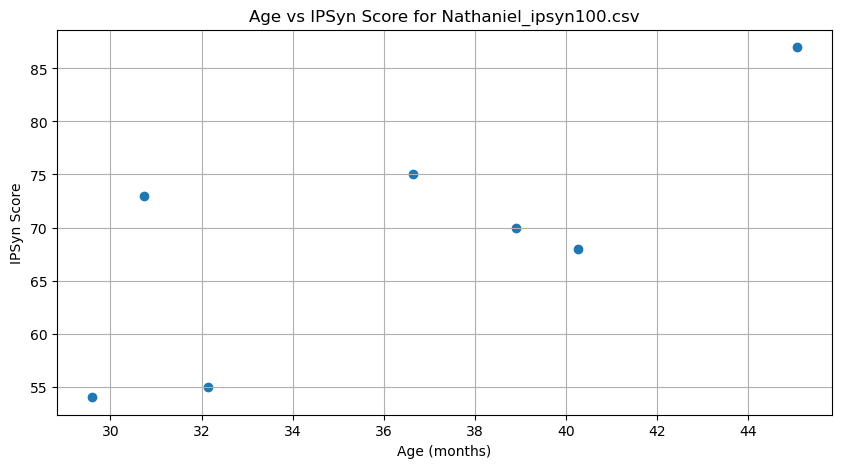

Spearman's rho for Nathaniel_ipsyn100.csv: 0.5714

Chosen Transcripts for Nathaniel_ipsyn100.csv: 
 ['020518a.cha', '020622a.cha', '020804a.cha', '030019b.cha', '030227a.cha', '030408b.cha', '030902.cha'] 

IPSyn Scores for Nathaniel_ipsyn100.csv: 
 [54.0, 73.0, 55.0, 75.0, 70.0, 68.0, 87.0] 

Ages for Nathaniel_ipsyn100.csv: 
 [29.6, 30.733333333333334, 32.13333333333333, 36.63333333333333, 38.9, 40.266666666666666, 45.06666666666666] 

Time Steps for Nathaniel_ipsyn100.csv: 
 [1.1333333333333329, 1.3999999999999986, 4.5, 2.2666666666666657, 1.3666666666666671, 4.799999999999997] 



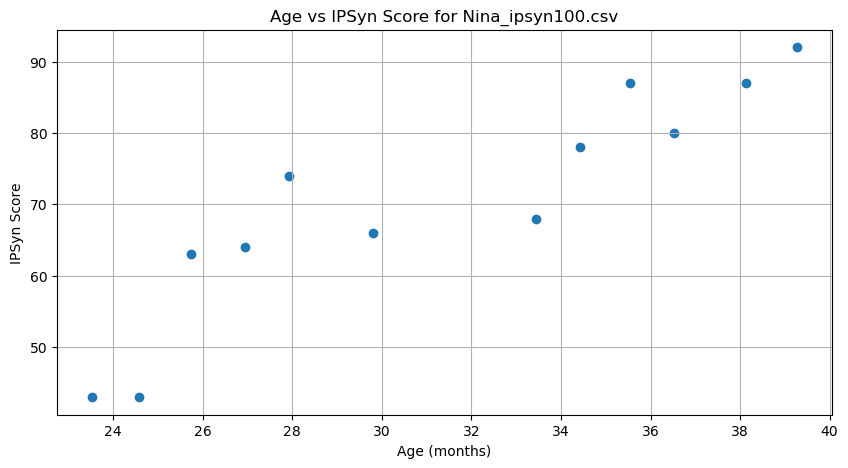

Spearman's rho for Nina_ipsyn100.csv: 0.9649

Chosen Transcripts for Nina_ipsyn100.csv: 
 ['011116.cha', '020017.cha', '020122.cha', '020228.cha', '020328.cha', '020524.cha', '020913.cha', '021013.cha', '021116.cha', '030016.cha', '030204.cha', '030308.cha'] 

IPSyn Scores for Nina_ipsyn100.csv: 
 [43.0, 43.0, 63.0, 64.0, 74.0, 66.0, 68.0, 78.0, 87.0, 80.0, 87.0, 92.0] 

Ages for Nina_ipsyn100.csv: 
 [23.53333333333333, 24.566666666666666, 25.733333333333334, 26.933333333333334, 27.933333333333334, 29.8, 33.43333333333334, 34.43333333333334, 35.53333333333333, 36.53333333333333, 38.13333333333333, 39.266666666666666] 

Time Steps for Nina_ipsyn100.csv: 
 [1.033333333333335, 1.1666666666666679, 1.1999999999999993, 1.0, 1.8666666666666671, 3.6333333333333364, 1.0, 1.0999999999999943, 1.0, 1.6000000000000014, 1.1333333333333329] 



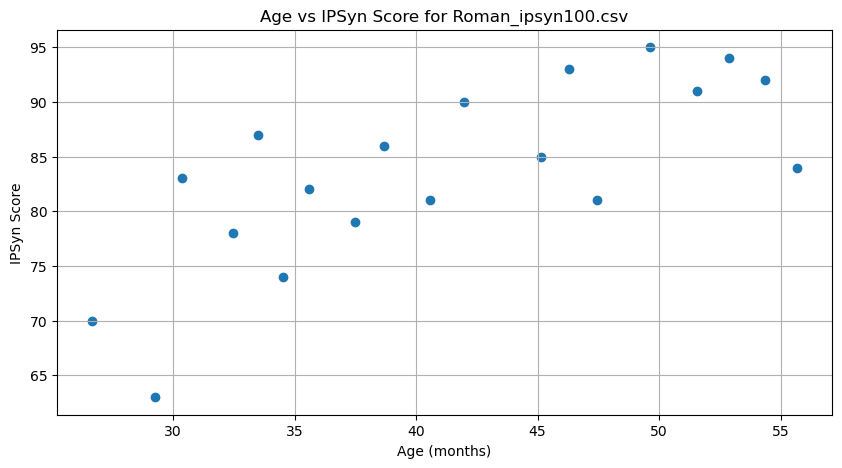

Spearman's rho for Roman_ipsyn100.csv: 0.7126

Chosen Transcripts for Roman_ipsyn100.csv: 
 ['020220.cha', '020507.cha', '020611.cha', '020814.cha', '020915.cha', '021015.cha', '021118.cha', '030114.cha', '030220.cha', '030417.cha', '030529.cha', '030904.cha', '031009.cha', '031113.cha', '040119.cha', '040317.cha', '040426.cha', '040611.cha', '040720.cha'] 

IPSyn Scores for Roman_ipsyn100.csv: 
 [70.0, 63.0, 83.0, 78.0, 87.0, 74.0, 82.0, 79.0, 86.0, 81.0, 90.0, 85.0, 93.0, 81.0, 95.0, 91.0, 94.0, 92.0, 84.0] 

Ages for Roman_ipsyn100.csv: 
 [26.666666666666668, 29.233333333333334, 30.366666666666667, 32.46666666666667, 33.5, 34.5, 35.6, 37.46666666666667, 38.666666666666664, 40.56666666666666, 41.96666666666667, 45.13333333333333, 46.3, 47.43333333333334, 49.63333333333333, 51.56666666666666, 52.86666666666667, 54.36666666666667, 55.666666666666664] 

Time Steps for Roman_ipsyn100.csv: 
 [2.5666666666666664, 1.1333333333333329, 2.1000000000000014, 1.0333333333333314, 1.0, 1.1000000000

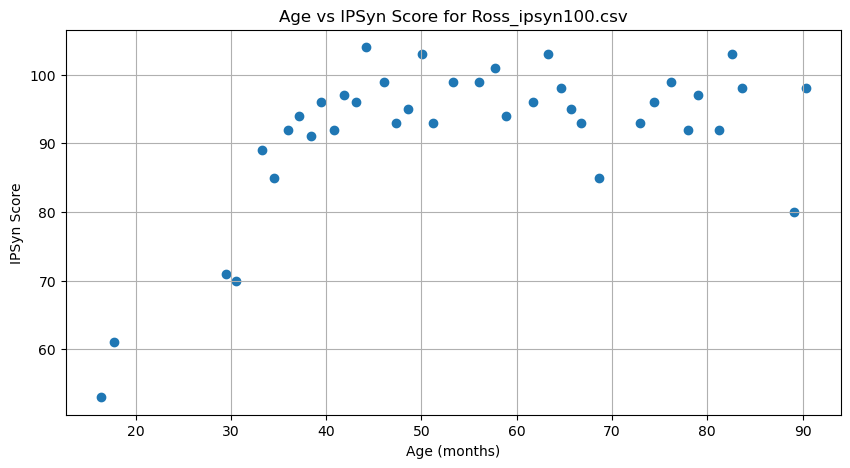

Spearman's rho for Ross_ipsyn100.csv: 0.4024

Chosen Transcripts for Ross_ipsyn100.csv: 
 ['010411a.cha', '010523.cha', '020514a.cha', '020617a.cha', '020909a.cha', '021017c.cha', '030001a.cha', '030105a.cha', '030213a.cha', '030315a.cha', '030426a.cha', '030526a.cha', '030704.cha', '030804.cha', '031001.cha', '031109.cha', '040019.cha', '040201.cha', '040305b.cha', '040508a.cha', '040800a.cha', '040920a.cha', '041027a.cha', '050120a.cha', '050309a.cha', '050420b.cha', '050520b.cha', '050622a.cha', '050820c.cha', '060027b.cha', '060211a2.cha', '060406b2.cha', '060530c.cha', '060701b.cha', '060906c.cha', '061017b.cha', '061119b.cha', '070503d.cha', '070600c.cha'] 

IPSyn Scores for Ross_ipsyn100.csv: 
 [53.0, 61.0, 71.0, 70.0, 89.0, 85.0, 92.0, 94.0, 91.0, 96.0, 92.0, 97.0, 96.0, 104.0, 99.0, 93.0, 95.0, 103.0, 93.0, 99.0, 99.0, 101.0, 94.0, 96.0, 103.0, 98.0, 95.0, 93.0, 85.0, 93.0, 96.0, 99.0, 92.0, 97.0, 92.0, 103.0, 98.0, 80.0, 98.0] 

Ages for Ross_ipsyn100.csv: 
 [16.3666666666666

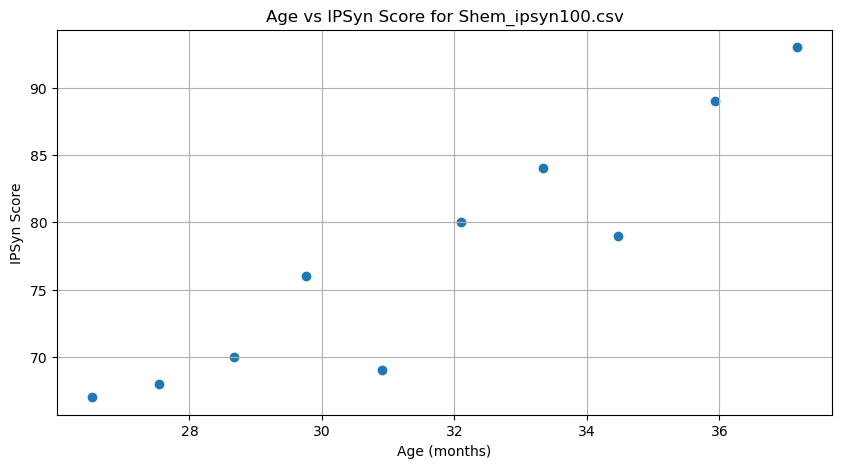

Spearman's rho for Shem_ipsyn100.csv: 0.9273

Chosen Transcripts for Shem_ipsyn100.csv: 
 ['020216.cha', '020316.cha', '020420.cha', '020523.cha', '020627.cha', '020803.cha', '020910.cha', '021014.cha', '021128.cha', '030105.cha'] 

IPSyn Scores for Shem_ipsyn100.csv: 
 [67.0, 68.0, 70.0, 76.0, 69.0, 80.0, 84.0, 79.0, 89.0, 93.0] 

Ages for Shem_ipsyn100.csv: 
 [26.53333333333333, 27.53333333333333, 28.666666666666668, 29.766666666666666, 30.9, 32.1, 33.333333333333336, 34.46666666666667, 35.93333333333334, 37.166666666666664] 

Time Steps for Shem_ipsyn100.csv: 
 [1.0, 1.1333333333333364, 1.0999999999999979, 1.1333333333333329, 1.2000000000000028, 1.2333333333333343, 1.1333333333333329, 1.4666666666666686, 1.2333333333333272] 



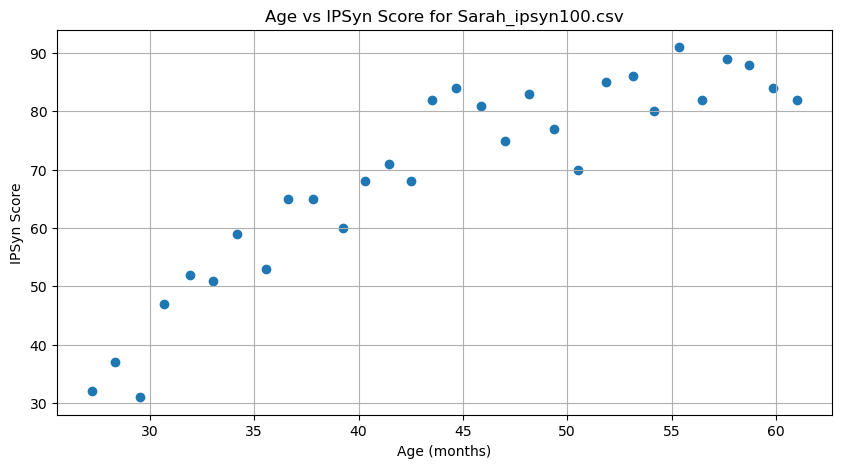

Spearman's rho for Sarah_ipsyn100.csv: 0.9028

Chosen Transcripts for Sarah_ipsyn100.csv: 
 ['020307.cha', '020410.cha', '020515.cha', '020620.cha', '020728.cha', '020900.cha', '021005.cha', '021117.cha', '030018a.cha', '030124.cha', '030307a.cha', '030409.cha', '030513.cha', '030616.cha', '030716.cha', '030820.cha', '030926a.cha', '031030.cha', '040005.cha', '040111.cha', '040216.cha', '040326.cha', '040504.cha', '040605.cha', '040711.cha', '040813.cha', '040919.cha', '041021.cha', '041126.cha', '050030.cha'] 

IPSyn Scores for Sarah_ipsyn100.csv: 
 [32.0, 37.0, 31.0, 47.0, 52.0, 51.0, 59.0, 53.0, 65.0, 65.0, 60.0, 68.0, 71.0, 68.0, 82.0, 84.0, 81.0, 75.0, 83.0, 77.0, 70.0, 85.0, 86.0, 80.0, 91.0, 82.0, 89.0, 88.0, 84.0, 82.0] 

Ages for Sarah_ipsyn100.csv: 
 [27.233333333333334, 28.333333333333332, 29.5, 30.666666666666668, 31.933333333333334, 33.0, 34.166666666666664, 35.56666666666666, 36.6, 37.8, 39.233333333333334, 40.3, 41.43333333333334, 42.53333333333333, 43.53333333333333, 44

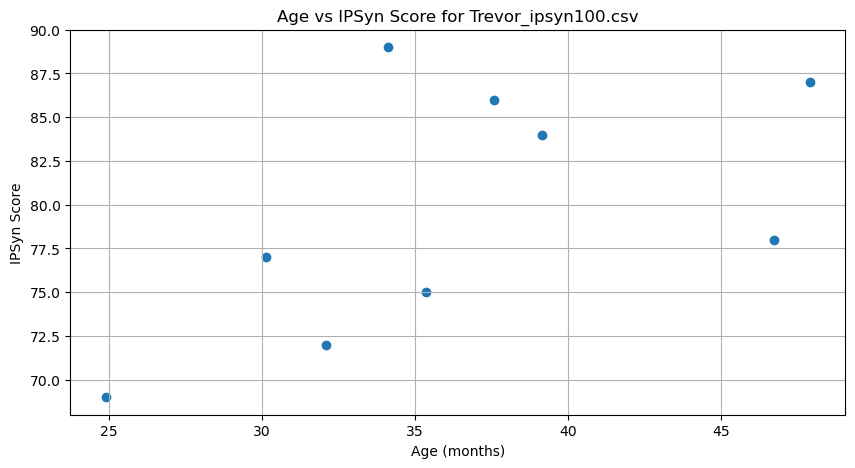

Spearman's rho for Trevor_ipsyn100.csv: 0.6167

Chosen Transcripts for Trevor_ipsyn100.csv: 
 ['020027.cha', '020604.cha', '020803.cha', '021004.cha', '021111.cha', '030117.cha', '030304.cha', '031022.cha', '031127a.cha'] 

IPSyn Scores for Trevor_ipsyn100.csv: 
 [69.0, 77.0, 72.0, 89.0, 75.0, 86.0, 84.0, 78.0, 87.0] 

Ages for Trevor_ipsyn100.csv: 
 [24.9, 30.133333333333333, 32.1, 34.13333333333333, 35.36666666666667, 37.56666666666667, 39.13333333333333, 46.733333333333334, 47.9] 

Time Steps for Trevor_ipsyn100.csv: 
 [5.233333333333334, 1.9666666666666686, 2.0333333333333314, 1.2333333333333343, 2.200000000000003, 1.5666666666666629, 7.600000000000001, 1.1666666666666643] 



In [6]:
age_ipsyn_plots(ipsyn_files_100, spearman_rhos_100, age_files)

## Spearman's ρ

In [7]:
spearman_rhos_50

[['Abe_ipsyn50.csv', 0.735251227036384],
 ['Adam_ipsyn50.csv', 0.8699083815459872],
 ['Benjamin_ipsyn50.csv', 0.753702346348183],
 ['Emily_ipsyn50.csv', 0.47083259720049164],
 ['Emma_ipsyn50.csv', 0.3163786500489702],
 ['Eve_ipsyn50.csv', 0.9695302189773755],
 ['Jillian_ipsyn50.csv', 0.3783937343321348],
 ['Laura_ipsyn50.csv', 0.9051077022053234],
 ['Matt_ipsyn50.csv', 0.6280913062599535],
 ['Naomi_ipsyn50.csv', 0.8928888428110756],
 ['Nathaniel_ipsyn50.csv', 0.8214285714285715],
 ['Nina_ipsyn50.csv', 0.9860139860139862],
 ['Roman_ipsyn50.csv', 0.588494142745897],
 ['Ross_ipsyn50.csv', 0.29314190878749086],
 ['Shem_ipsyn50.csv', 0.9179373709568976],
 ['Sarah_ipsyn50.csv', 0.9136503011085346],
 ['Trevor_ipsyn50.csv', 0.6945667492672501]]

In [8]:
spearman_rhos_100

[['Abe_ipsyn100.csv', 0.6585111904871099],
 ['Adam_ipsyn100.csv', 0.8586589056708851],
 ['Benjamin_ipsyn100.csv', 0.9856107606091623],
 ['Emily_ipsyn100.csv', 0.38084321268764704],
 ['Emma_ipsyn100.csv', 0.4618855024118177],
 ['Eve_ipsyn100.csv', 0.9726488698881034],
 ['Jillian_ipsyn100.csv', 0.4642857142857144],
 ['Laura_ipsyn100.csv', 0.9205993700436056],
 ['Matt_ipsyn100.csv', 0.5883549742801504],
 ['Naomi_ipsyn100.csv', 0.911764705882353],
 ['Nathaniel_ipsyn100.csv', 0.5714285714285715],
 ['Nina_ipsyn100.csv', 0.9649182205059428],
 ['Roman_ipsyn100.csv', 0.7125933112501274],
 ['Ross_ipsyn100.csv', 0.40237607081812],
 ['Shem_ipsyn100.csv', 0.9272727272727272],
 ['Sarah_ipsyn100.csv', 0.9028167051451762],
 ['Trevor_ipsyn100.csv', 0.6166666666666666]]